In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce

datadir = "/Users/chris/Documents/QPP/SolarFlareGPs/data/daniela_goes_data/"
i=0
burst_array=[]
dim = 3
N = np.power(dim,2)

while i<N:
    burstid = np.random.randint(1520110128,1520170715) #1520111001 
    try:
        time, flux, header = qpp.load_data(datadir,burstid, returnhead=True)
    except(IOError):
        pass
    else:
        i+=1
        time, flux = qpp.load_data(datadir,burstid)
        tt,ft = qpp.trim_data(time,flux, cutoff = .2)
        ft = ft*1e10  #cheating conversions!!!
        ft_err = np.sqrt(ft)
        burst_array.append(burstid)
print burst_array

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[1520120206, 1520140701, 1520110910, 1520140614, 1520141107, 1520140102, 1520140506, 1520150408, 1520110214]


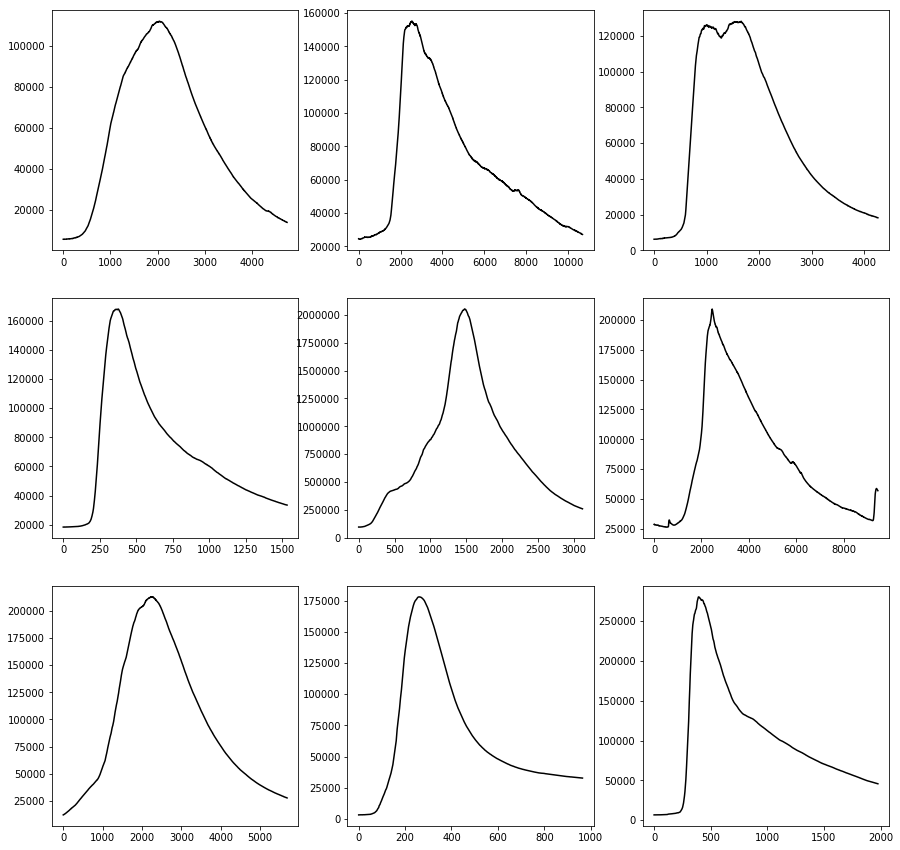

In [2]:
time_array = []
flux_array = []
for burst in burst_array:
    time, flux = qpp.load_data(datadir,burst)
    tt,ft = qpp.trim_data(time,flux, cutoff = .2)
    ft = ft*1e10 
    time_array.append(tt)
    flux_array.append(ft)
    
flarefig, flareax = plt.subplots(dim,dim, figsize=(15,15))
for i in range(len(burst_array)):
    flareax[i/3,i%3].plot(time_array[i], flux_array[i], 'k-')
plt.show()

QPP_Funcs.py:27: RuntimeWarning: divide by zero encountered in divide
  return A*lam*np.exp((-tau1/t)-(t/tau2))
QPP_Funcs.py:53: RuntimeWarning: divide by zero encountered in log
  return np.log(probA * probtau1 * probtau2 * np.e)


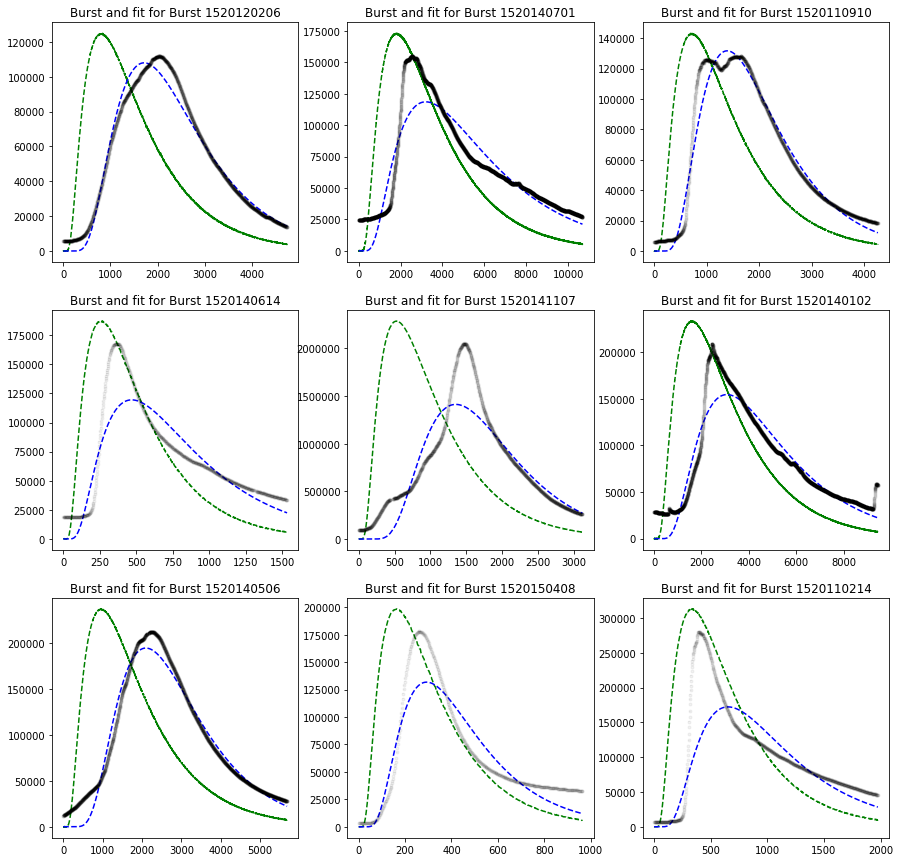

'\ninitparams = gp.get_parameter_vector()\nprint("Initial log-parameters:" + str(initparams))\n'

In [3]:
gp_array = []
fitfig, fitax = plt.subplots(dim,dim, figsize=(15,15))


for i in range(len(burst_array)):
    tt = time_array[i]
    ft = flux_array[i]
    ft_err = np.sqrt(ft)
    A_guess, t1_guess, t2_guess = qpp.initguess(tt,ft)
    model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
    kernel1 = qpp.SHOTerm_Prior(log_S0 = 1, log_Q = 1, log_omega0 = 0) #write guesser for kernel parameters
    kernel2 = qpp.RealTerm_Prior(log_a=0., log_c=0.) #write guesser for kernel parameters
    kernel = kernel2 + kernel1
    gp = ce.GP(kernel, mean=model, fit_mean=True)
    gp.compute(tt, ft_err)
    fitax[i/3, i%3].plot(tt, gp.sample(), 'g--', label = "Prior Sample")
    #qpp.plot_gp_subplot(fitax[i/3, i%3], tt,ft, ft_err, gp, model, predict_color='r--', label="Initial Guess", burstid=burst_array[i])
    soln = qpp.optimize_gp(gp, ft)
    gp.set_parameter_vector(soln.x)
    qpp.plot_gp_subplot(fitax[i/3, i%3], tt,ft, ft_err, gp, model, predict_color='b--', label="Optimized Guess", burstid=burst_array[i])
    gp_array.append(gp)
plt.show()
'''
initparams = gp.get_parameter_vector()
print("Initial log-parameters:" + str(initparams))
'''

In [4]:
chain_array = []

for i in range(N):
    print("Sampling burst " + str(burst_array[i]) + "\t#" + str(i+1))
    tt = time_array[i]
    ft = flux_array[i]
    ft_err = np.sqrt(ft)
    gp = gp_array[i]
    model = gp.mean
    initparams = gp.get_parameter_vector()
    sampler = qpp.sample_gp(initparams, ft, gp, burnin=3000, nwalkers=100, nsteps = 3000)
    chain = sampler.chain
    chain_array.append(chain)

Sampling burst 1520120206	#1


QPP_Funcs.py:71: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
QPP_Funcs.py:86: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_a*prob_c * np.e)


Sampling burst 1520140701	#2


QPP_Funcs.py:26: RuntimeWarning: overflow encountered in exp
  lam = np.exp(np.sqrt(2*np.exp(tau1/tau2)))
QPP_Funcs.py:27: RuntimeWarning: invalid value encountered in multiply
  return A*lam*np.exp((-tau1/t)-(t/tau2))


Sampling burst 1520110910	#3
Sampling burst 1520140614	#4
Sampling burst 1520141107	#5
Sampling burst 1520140102	#6
Sampling burst 1520140506	#7
Sampling burst 1520150408	#8
Sampling burst 1520110214	#9


Sampling burst 1520120206	#1


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/celerite/celerite.py:505: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu, cov, size=size)


Sampling burst 1520140701	#2
Sampling burst 1520110910	#3
Sampling burst 1520140614	#4
Sampling burst 1520141107	#5
Sampling burst 1520140102	#6
Sampling burst 1520140506	#7
Sampling burst 1520150408	#8
Sampling burst 1520110214	#9


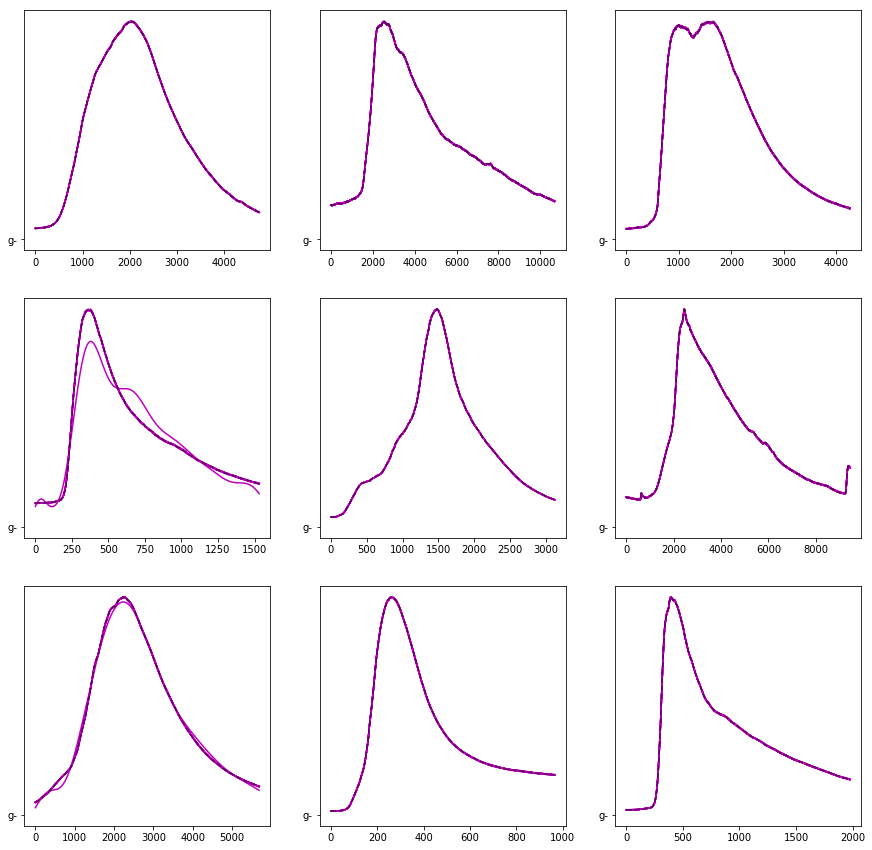

In [5]:
postfig, postax = plt.subplots(dim,dim, figsize=(15,15))
for i in range(N):
    print("Sampling burst " + str(burst_array[i]) + "\t#" + str(i+1))
    tt = time_array[i]
    ft = flux_array[i]
    ft_err = np.sqrt(ft)
    gp = gp_array[i]
    model = gp.mean
    chain = chain_array[i]
    nsteps = len(chain[0])
    nwalkers = len(chain)
    for j in range(9):
        params = chain[np.random.randint(nwalkers),nsteps-1]
        qpp.plot_post_subplot(postax[i/3, i%3], tt, ft, ft_err, gp, params)#, alpha = 0.25)
    postax[i/3, i%3].plot(tt,ft, 'k--', alpha=0.5)
plt.show()

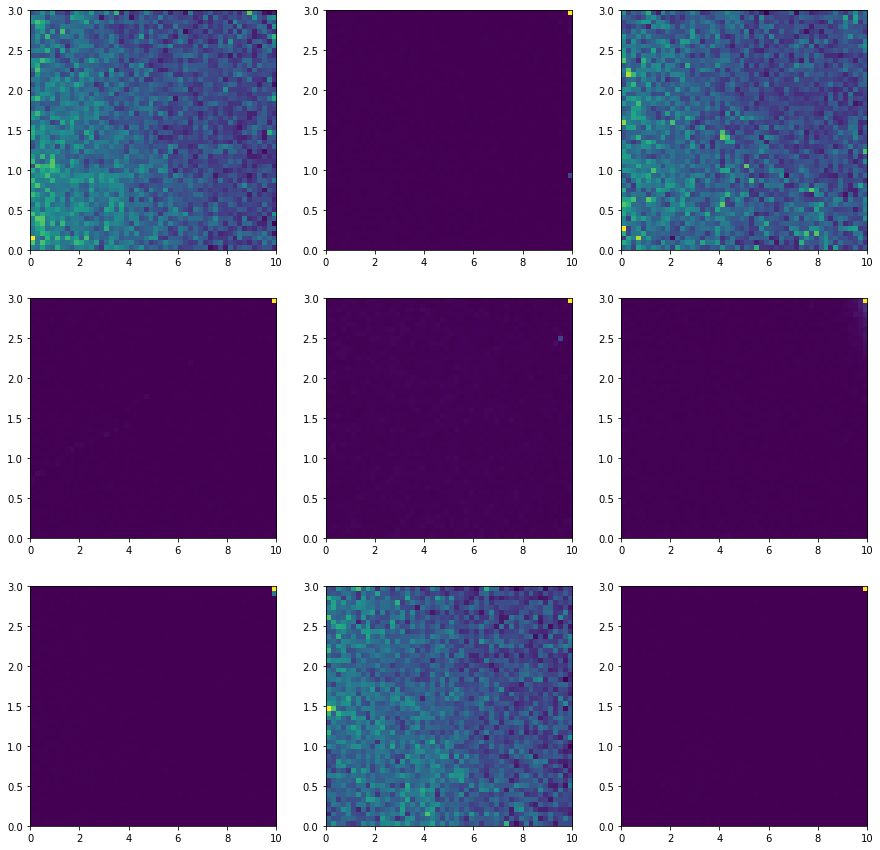

In [9]:
histfig, histax = plt.subplots(dim,dim, figsize=(15,15))#, sharex=True, sharey=True)

for i in range(N):
    chain = chain_array[i]
    s0_chain = (chain[:,:,2]).flatten()
    Q_chain = (chain[:,:,3]).flatten()
    histax[i/3, i%3].hist2d(s0_chain, Q_chain,bins=50)#, range=[[0,10],[0,3]])
    
plt.show()


In [7]:
print gp_array[0].sample()

[ -303.87990155  -116.38178109   -33.52884342 ... 16718.53667634
 16010.69824182 16126.30301731]


In [8]:
%load_ext autoreload
%autoreload 2